### Recupera a data de criação do arquivo csv

In [0]:
import os
import platform
from datetime import datetime

def creation_date(path_to_file):
    """
    Try to get the date that a file was created, falling back to when it was
    last modified if that isn't possible.
    See http://stackoverflow.com/a/39501288/1709587 for explanation.
    """
    if platform.system() == 'Windows':
        return os.path.getctime(path_to_file)
    else:
        stat = os.stat(path_to_file)
        try:
            return stat.st_birthtime
        except AttributeError:
            # We're probably on Linux. No easy way to get creation dates here,
            # so we'll settle for when its content was last modified.
            return stat.st_mtime

csv_file = 'Resultado do Scraping (LinkedIn).csv'
print(datetime.fromtimestamp(creation_date(csv_file)))

2019-11-13 21:30:26.097214


### Cria dicionário de tags de tecnologia

In [0]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time

tag_list = []

for page in range(1, 92):
  print(f'Page {page}')
  site = f'https://pt.stackoverflow.com/tags?page={page}&tab=popular'

  response = requests.get(site)

  html = BeautifulSoup(response.text, 'html.parser')
  tags = html.find_all('a', attrs = {'class': 'post-tag'})
  tag_list = tag_list + [tag.get_text() for tag in tags]
  time.sleep(0.5)
  
df_tags = pd.DataFrame(tag_list, columns = ['tag'])
df_tags.to_csv('tags_stackoverflow_pt.csv', index = False)

### Carrega o arquivo csv e inicia a análise 

#### Usando as tags do stackoverflow

In [0]:
# Lembrete: Carregar os arquivos antes
import pandas as pd

# Data do arquivo da base: 12/11/2019
base_file_path = 'Resultado do Scraping (LinkedIn).csv'
df_vagas = pd.read_csv(base_file_path)

# Carrega e prepara o arquivo de tags (stackoverflow)
df_tags = pd.read_csv('tags_stackoverflow_pt.csv')
df_tags.insert(1, "count", [0 for x in range(len(df_tags))], True)
df_tags = df_tags.dropna().reindex()

# Itera no texto completo das vagas e conta a ocorrência das tags
for v, text in zip(range(len(df_vagas)), df_vagas['fulltext']):
  print(f'Vaga {v+1}')
  for i in range(len(df_tags)):
    if df_tags['tag'].iloc[i] in text:
      df_tags.iat[i, 1] += 1

# Ordena pela coluna count
df_tags.sort_values('count', ascending = False)

#### Usando as tags geradas pelo nosso formulário (análise oficial)

In [0]:
# Lembrete: Carregar os arquivos antes
import pandas as pd
import re

# Data do arquivo da base: 22/11/2019
base_file_path = 'Resultado do Scraping (LinkedIn).csv'
df_vagas = pd.read_csv(base_file_path)
df_vagas.head()

# Carrega e prepara o arquivo de tags (formulário)
# dict_tags = {}
tag_list = []
type_tag_list = []

tags_file = open('search-terms.txt','r')
raw_tags = tags_file.read()
raw_tags = raw_tags.split('##')

# Adequa as tags e suas categorias
for item in raw_tags:
  if item == '':
    continue
  tags_aux = item.split('\n\n')
  tags_type = tags_aux[0].strip('\n# ').lower().replace(' ','_')
  tags = tags_aux[1].split()
  type_tag_list += [tags_type]*len(tags)
  tag_list += tags
#   dict_tags[tags_type] = tags

df_tags = pd.DataFrame([tag_list, type_tag_list]).T
df_tags.columns = ['tag','tag_type']
df_tags.insert(1, "count", [0 for x in range(len(df_tags))], True)
df_tags = df_tags.dropna().reindex()

# Itera no texto completo das vagas e conta a ocorrência das tags
# TODO: Conferir o algoritmo de contagem
for v, text in zip(range(len(df_vagas)), df_vagas['fulltext']):
#   print(f'Vaga {v+1}')
  for i in range(len(df_tags)):
    tech = df_tags['tag'].iloc[i].lower()
    text = text.lower()
    if tech == 'c':
      continue # Desconsidera a linguagem C
      regex_out = re.search('[^a-z][cC][^a-z+#]', text)
      if regex_out:
        df_tags.iat[i, 1] += 1
    elif tech in text:
      df_tags.iat[i, 1] += 1


# Ordena pela coluna count
df_tags_sorted = df_tags.sort_values(['tag_type','count'], ascending = False)
df_tags_sorted.to_csv('df_tags_sorted.csv', index = False)

,tag,count,tag_type
60,Node,36,servidores
61,Jboss,30,servidores
54,Apache,21,servidores
56,Express,16,servidores
58,WebSphere,16,servidores
...,...,...,...
48,MySQL,33,banco_de_dados
46,DB2,31,banco_de_dados
47,MongoDB,15,banco_de_dados
51,Redis,2,banco_de_dados


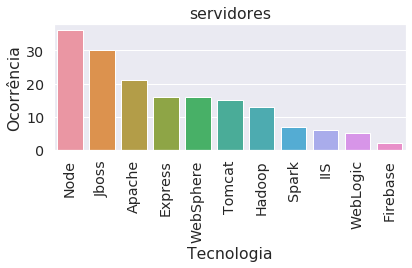

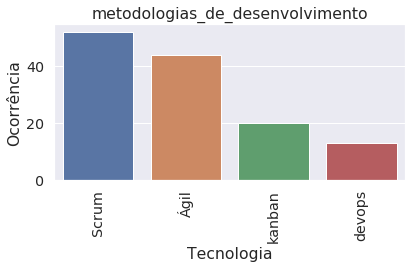

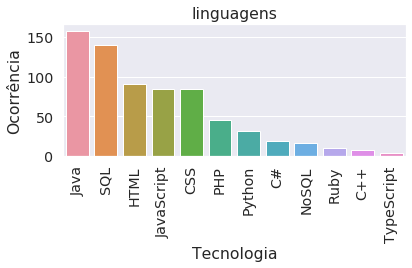

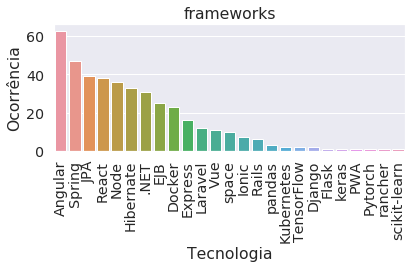

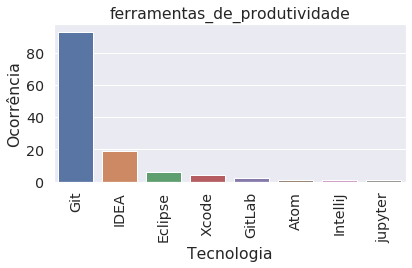

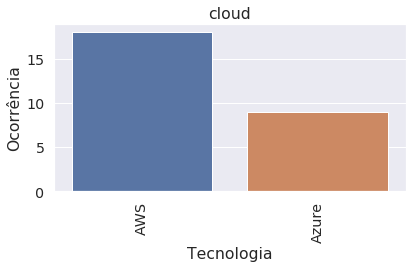

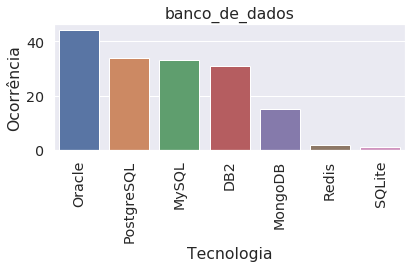

In [0]:
# Gráficos (barras e mapa)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.3)

df_tags_sorted = pd.read_csv('df_tags_sorted.csv')
df_tags_sorted.drop_duplicates(inplace=True)

categorias = df_tags_sorted['tag_type'].unique()

for c in categorias:
  filtro = (df_tags_sorted['tag_type'] == c) & (df_tags_sorted['count'] != 0)
  df_temp = df_tags_sorted[filtro]

  plt.figure()
  ax = sns.barplot(x='tag', y='count', data=df_temp)
  ax.set_title(c)
  ax.set_xlabel('Tecnologia')#, fontsize=14)
  ax.set_ylabel('Ocorrência')
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.savefig(c+'.png', format='png', dpi=300)